In [ ]:
!pip install selenium

     |████████████████████████████████| 968 kB 5.2 MB/s 
     |████████████████████████████████| 359 kB 37.9 MB/s 
     |████████████████████████████████| 138 kB 55.2 MB/s 
     |████████████████████████████████| 3.6 MB 38.7 MB/s 
     |████████████████████████████████| 55 kB 3.7 MB/s 
     |████████████████████████████████| 58 kB 5.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
'''from selenium import webdriver'''

from PIL import Image
from bs4 import BeautifulSoup

import networkx as nx

import pickle

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df= pd.read_csv("/content/phishing_site_urls.csv")

In [ ]:
df.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [ ]:
df.isnull().sum()

URL      0
Label    0
dtype: int64

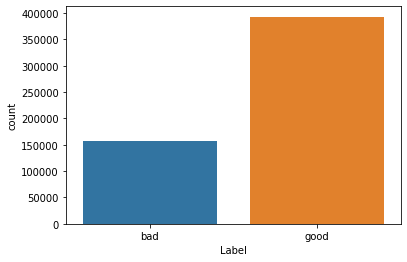

In [ ]:
sns.countplot(x="Label",data=df)

In [ ]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [ ]:
tokenizer

RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)

In [ ]:
tokenizer.tokenize(df.URL[1])

['www',
 'dghjdgf',
 'com',
 'paypal',
 'co',
 'uk',
 'cycgi',
 'bin',
 'webscrcmd',
 'home',
 'customer',
 'nav',
 'loading',
 'php']

In [ ]:
tokenizer.tokenize(df.Label[1])

['bad']

In [ ]:
print('Getting words tokenized ...')
t0= time.perf_counter()
df['text_tokenized'] = df.URL.map(lambda t: tokenizer.tokenize(t))
t1 = time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words tokenized ...
Time taken 2.3939576829999965 sec


In [ ]:
df.sample(5)

,URL,Label,text_tokenized
188635,flightaware.com/live/fleet/TSC,good,"[flightaware, com, live, fleet, TSC]"
104063,leolinepackersandmovers.com/order2/DHL/trackin...,bad,"[leolinepackersandmovers, com, order, DHL, tra..."
81374,sourceforge.net/projects/macthemes/,good,"[sourceforge, net, projects, macthemes]"
150676,blog.richmond.edu/openwidelookinside/archives/...,good,"[blog, richmond, edu, openwidelookinside, arch..."
36019,sicakeller.org/wp-content/uploads/globalsource...,bad,"[sicakeller, org, wp, content, uploads, global..."


In [ ]:
stemmer = SnowballStemmer("english")

In [ ]:
# Getting all the stemmed words
print('Getting words stemmed ...')
t0= time.perf_counter()
df['text_stemmed'] = df['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words stemmed ...
Time taken 53.791361388999974 sec


In [ ]:
df.sample(5)

,URL,Label,text_tokenized,text_stemmed
133514,paigemduke.com/wp-admin/Valid,bad,"[paigemduke, com, wp, admin, Valid]","[paigemduk, com, wp, admin, valid]"
184561,espn.go.com/mens-college-basketball/team/_/id/...,good,"[espn, go, com, mens, college, basketball, tea...","[espn, go, com, men, colleg, basketbal, team, ..."
510364,centinel.ca/wkr1j6n,bad,"[centinel, ca, wkr, j, n]","[centinel, ca, wkr, j, n]"
184921,espn.go.com/nhl/team/schedule/_/name/col/color...,good,"[espn, go, com, nhl, team, schedule, name, col...","[espn, go, com, nhl, team, schedul, name, col,..."
90471,magliery.com/Set/SetQuarto.html,good,"[magliery, com, Set, SetQuarto, html]","[maglieri, com, set, setquarto, html]"


In [ ]:
# Joining all the stemmmed words.
print('Get joiningwords ...')
t0= time.perf_counter()
df['text_sent'] = df['text_stemmed'].map(lambda l: ' '.join(l))
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Get joiningwords ...
Time taken 0.26555852499996035 sec


In [ ]:
bad_sites = df[df.Label == 'bad']
good_sites = df[df.Label == 'good']

In [ ]:

good_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


In [ ]:
df.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [ ]:
cv = CountVectorizer()

In [ ]:
feature = cv.fit_transform(df.text_sent) #transform all text which we tokenize and stemed

In [ ]:
feature[:5].toarray() # convert sparse matrix into array to print transformed features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
list_urls = ['https://www.ezeephones.com/','https://www.ezeephones.com/about-us']
links_with_text = []

In [ ]:
for url in list_urls:
    browser.get(url)
    soup = BeautifulSoup(browser.page_source,"html.parser")
    for line in soup.find_all('a'):
        href = line.get('href')
        links_with_text.append([url, href])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
trainX, testX, trainY, testY = train_test_split(feature, df.Label)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression()
lr.fit(trainX,trainY)

LogisticRegression()

In [ ]:
lr.score(testX,testY)

0.9634184524199597

Logistic Regression provide 97% accuracy,Now we will store the score in the dictionary so that we can find which model performs the best.

In [ ]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

Training Accuracy : 0.978024751886488
Testing Accuracy : 0.9634184524199597

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.96      0.93     36889
        Good       0.99      0.96      0.97    100448

    accuracy                           0.96    137337
   macro avg       0.95      0.96      0.95    137337
weighted avg       0.96      0.96      0.96    137337


CONFUSION MATRIX


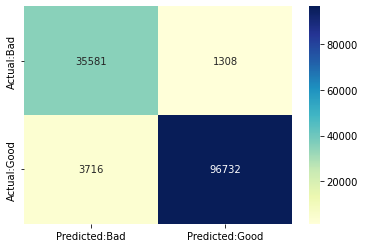

In [ ]:
# creating confusing matrix
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [ ]:
from sklearn.naive_bayes import MultinomialNB

MultinomialNB
The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work

In [ ]:
mnb = MultinomialNB()

In [ ]:
mnb.fit(trainX,trainY)

MultinomialNB()

In [ ]:
mnb.score(testX,testY)

0.9569526056343156

MultinomialNB provide 95% accuracy,so we can store the score in the dictionary

In [ ]:
Scores_ml['MultinomialNB'] = np.round(mnb.score(testX,testY),2)

Training Accuracy : 0.9741777485443279
Testing Accuracy : 0.9564938800177665

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.93      0.92     38216
        Good       0.97      0.97      0.97     99121

    accuracy                           0.96    137337
   macro avg       0.94      0.95      0.95    137337
weighted avg       0.96      0.96      0.96    137337


CONFUSION MATRIX


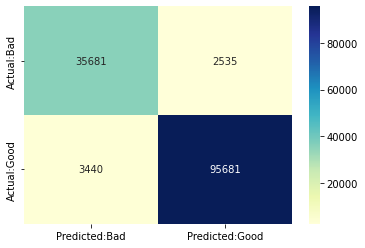

In [ ]:
print('Training Accuracy :',mnb.score(trainX,trainY))
print('Testing Accuracy :',mnb.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(mnb.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(mnb.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

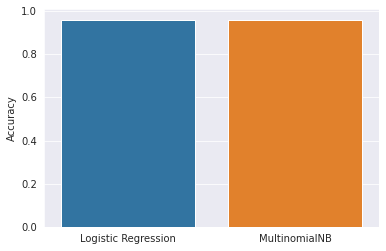

In [ ]:
acc = pd.DataFrame.from_dict(Scores_ml,orient = 'index',columns=['Accuracy'])
sns.set_style('darkgrid')
sns.barplot(acc.index,acc.Accuracy)

So, Logistic Regression is the best fit model, Now lets make sklearn pipeline using Logistic Regression

In [ ]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())

In [ ]:
trainX, testX, trainY, testY = train_test_split(df.URL, df.Label)

In [ ]:
pipeline_ls.fit(trainX,trainY)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>)),
                ('logisticregression', LogisticRegression())])

In [ ]:
pipeline_ls.score(testX,testY)

0.9669280674545097

Training Accuracy : 0.9805392600647074
Testing Accuracy : 0.9669280674545097

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     37012
        Good       0.99      0.97      0.98    100325

    accuracy                           0.97    137337
   macro avg       0.95      0.97      0.96    137337
weighted avg       0.97      0.97      0.97    137337


CONFUSION MATRIX


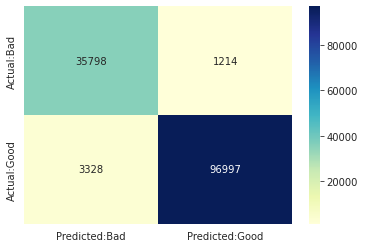

In [ ]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

Lets dump the model in pickle

In [ ]:
pickle.dump(pipeline_ls,open('phishing.pkl','wb'))

In [ ]:
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.9669280674545097
